In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-10 17:31:00.989856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 17:31:01.566519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
batch_size = 128
dataset_take = 1000
learning_rate = 1.5e-3
batch_per_file_size = 8
node_embedding_size = 15
layers = [96, 48, 32, 32, 24]

dataset = LayoutDataset(
    batch_size, dataset_take,
    subset=None, build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-10 17:31:12.570757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 17:31:12.595780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 17:31:12.596022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

train layout:nlp:default 1000
train layout:nlp:random 1000
train layout:xla:random 3000
train layout:xla:default 3000
test all_filenames 10000
valid all_filenames 1000


In [5]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    n_siblings=dataset.n_siblings
)

In [6]:
mlp.train(dataset, None)

2023-11-10 17:35:02.484888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-10 17:35:02.526314: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7515743190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 17:35:02.526337: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-10 17:35:02.564093: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-10 17:35:02.817680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-10 17:35:03.009630: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.5487728 lr 0.00007
iteration 1000 training loss 2.983625 lr 0.00015
iteration 1500 training loss 2.5167751 lr 0.00022
iteration 2000 training loss 2.5934365 lr 0.00030
iteration 2500 training loss 2.4361815 lr 0.00037
iteration 3000 training loss 2.6045852 lr 0.00045
iteration 3500 training loss 2.2625349 lr 0.00052
iteration 4000 training loss 1.9562658 lr 0.00060
iteration 4500 training loss 2.0631495 lr 0.00067
iteration 5000 training loss 2.0635629 lr 0.00075
iteration 5500 training loss 1.8570641 lr 0.00082
iteration 6000 training loss 2.1428125 lr 0.00090
iteration 6500 training loss 2.0248249 lr 0.00097
iteration 7000 training loss 1.9600668 lr 0.00105
iteration 7500 training loss 2.1365743 lr 0.00112
iteration 8000 training loss 1.8022008 lr 0.00120
iteration 8500 training loss 1.4973764 lr 0.00127
iteration 9000 training loss 2.1193976 lr 0.00135
iteration 9500 training loss 1.3786533 lr 0.00142
iteration 10000 training loss 1.6982574 lr 0.00150
l

KeyboardInterrupt: 

## Evaluate validation set

In [7]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

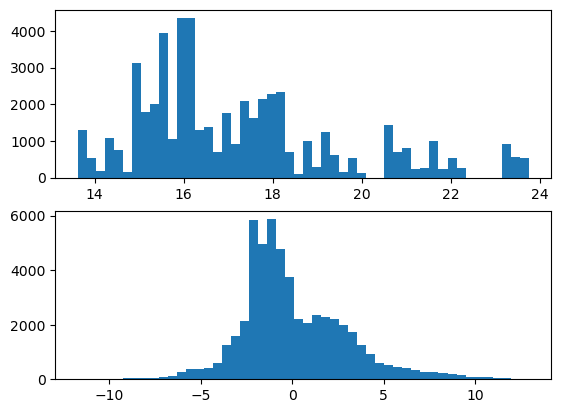

In [8]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [9]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:xla:random:unet_3d.4x4.bf16',b'layout:xla:random:unet_3d.4x4.bf16',0,-11.703248,20.629919
b'layout:xla:default:unet_3d.4x4.bf16',b'layout:xla:default:unet_3d.4x4.bf16',3,-11.547769,20.629910
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,105,-9.155890,15.867444
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,11,-8.810658,16.527241
b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train',b'layout:nlp:random:small_bert_bert_en_uncased...,28,-8.473318,15.196370
b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,56,-8.258215,16.078274
b'layout:nlp:random:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:random:bert_multi_cased_L-12_H-76...,39,-8.151713,17.404469
b'layout:nlp:random:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,21,-8.109936,18.142103
b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_32_train',b'layout:nlp:random:small_bert_bert_en_uncased...,45,-7.916968,17.015936


Text(0.5, 1.0, "b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_32_train'")

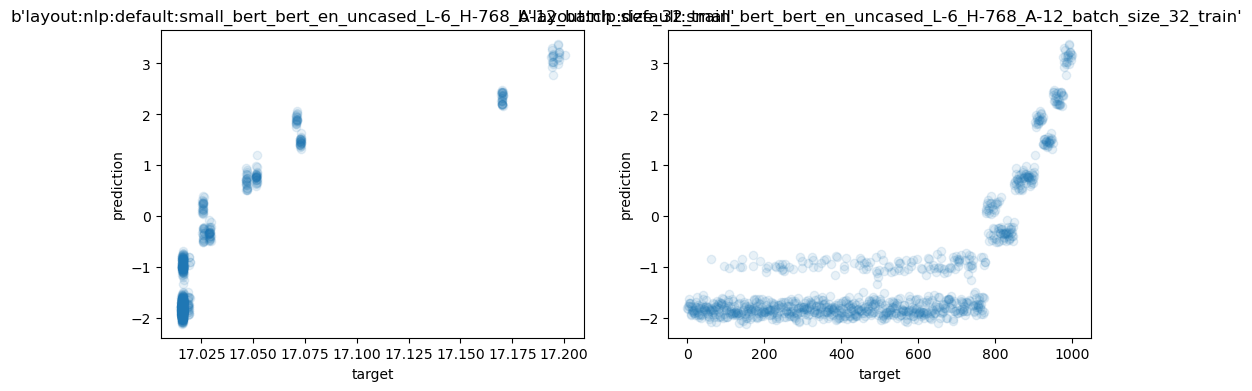

In [10]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

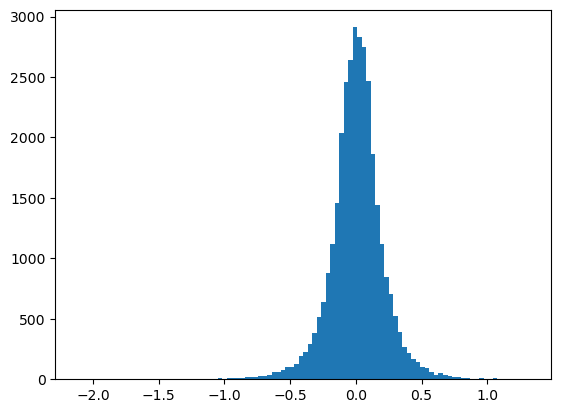

In [11]:
plt.hist(mlp.dense_layer_node_1.kernel.numpy().flatten(), bins=100);

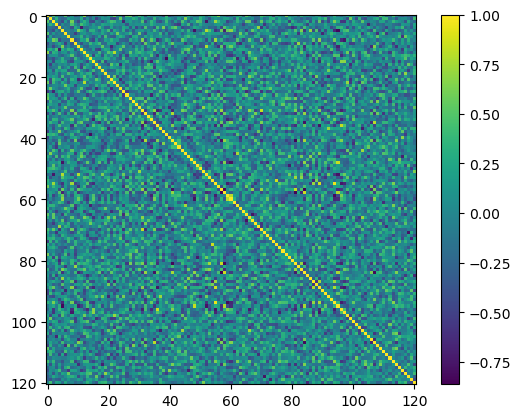

In [12]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [13]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

In [14]:
val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               11050;35882;22129;9316;19110;2572;29637;19299;...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  56300;55232;41229;43333;79431;51874;30853;1390...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              22621;3766;3472;17355;17461;3226;3213;14661;11...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      40216;83172;61979;61979;35652;74230;83110;8225...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     13849;324;3332;13840;821;21491;21679;45693;257...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      34371;20168;42242;55015;81786;38496;32928;7859...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     35921;23312;4001;34612;16215;34198;587;23735;2...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [15]:
val_df

,ID,config_index,prediction,target
0,b'layout:nlp:default:small_bert_bert_en_uncase...,19251,2.868648,16.612234
1,b'layout:nlp:default:small_bert_bert_en_uncase...,8487,-0.834606,16.101257
2,b'layout:nlp:default:small_bert_bert_en_uncase...,2237,-0.965290,16.102709
3,b'layout:nlp:random:small_bert_bert_en_uncased...,2187,2.105920,16.118732
4,b'layout:nlp:random:small_bert_bert_en_uncased...,85801,7.693232,16.255255
...,...,...,...,...
53437,b'layout:nlp:default:small_bert_bert_en_uncase...,2490,-0.114016,15.973392
53438,b'layout:nlp:default:small_bert_bert_en_uncase...,64179,1.689238,15.999410
53439,b'layout:nlp:default:small_bert_bert_en_uncase...,62405,1.545304,15.993576
53440,b'layout:nlp:default:small_bert_bert_en_uncase...,9029,-0.670538,15.973450


In [16]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:nlp:default', 'layout:nlp:random', 'layout:xla:default',
       'layout:xla:random'], dtype=object)

In [18]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
all_means = []
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    all_means.append(mean)
    print(subset, mean)
print(np.mean(all_means))

layout:nlp:default 0.4701781302714883
layout:nlp:random 0.8658136004188671
layout:xla:default 0.32140371835516085
layout:xla:random 0.5960871647537431
0.5633706534498149


In [19]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.026137
b'layout:xla:default:unet_3d.4x4.bf16'                                                  0.030473
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.105299
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train'     0.244783
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.334678
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.365164
b'layout:xla:default:inception_v3_batch_128_train'                                      0.409328
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.412382
b'layout:nlp:default:albert_en_xlarge_batch_size_16_test'                               0.414157
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test'      0.420313
b'layout:nlp:default:small_

In [ ]:
valid_nodes_list = []
for batch in dataset.valid_data:
    df = pd.DataFrame(
        np.stack([
            batch['layout_id'].numpy(), 
            batch['valid_nodes'].numpy()], axis=-1),
        columns=['ID', 'valid_nodes']
    ).drop_duplicates('ID')
    valid_nodes_list.append(df)
valid_nodes = pd.concat(valid_nodes_list).drop_duplicates('ID')
valid_nodes

In [ ]:
valid_nodes.set_index('ID', inplace=True)
valid_nodes['scores'] = val_scores
valid_nodes

In [ ]:
valid_nodes.reset_index(inplace=True)
valid_nodes

In [ ]:
valid_nodes['subset'] = valid_nodes['ID'].apply(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
valid_nodes

In [ ]:
plt.scatter(
    valid_nodes['scores'],
    valid_nodes['valid_nodes']
)

In [ ]:
subset = 'layout:nlp:default'
valid_nodes_subset = valid_nodes[valid_nodes['subset'] == subset]
print(valid_nodes_subset.sort_values('valid_nodes').iloc[-1])
plt.scatter(
    valid_nodes_subset['scores'],
    valid_nodes_subset['valid_nodes']
)

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [ ]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

In [ ]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

In [ ]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_none_test_prediction_11_07_01_33.csv')